# Drug-Likeness & Toxicity Integration

This notebook evaluates the **drug-likeness** of compounds using:
- Lipinski’s Rule of Five
- QED (Quantitative Estimate of Drug-likeness)

It then connects **drug-likeness** with:
- Important molecular descriptors identified by Random Forest toxicity models
- Predicted toxicity outcomes

This final stage bridges **cheminformatics descriptors**, **machine learning toxicity prediction**, and **medicinal chemistry decision-making**.


In [15]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors, QED

# Paths
BASE_DIR = Path("..")
DATA_PROCESSED = BASE_DIR / "data" / "processed"
RESULTS_DIR = BASE_DIR / "results"
FIGURES_DIR = RESULTS_DIR / "figures"
METRICS_DIR = RESULTS_DIR / "metrics"

FIGURES_DIR.mkdir(exist_ok=True)
METRICS_DIR.mkdir(exist_ok=True)

In [2]:
# Load descriptors
X_desc = pd.read_csv(DATA_PROCESSED / "tox21_descriptors.csv")

# Load SMILES from clean dataset
tox21_clean = pd.read_csv(DATA_PROCESSED / "tox21_clean.csv")

# Merge safely
df = pd.concat([tox21_clean[["smiles"]], X_desc], axis=1)

df.head()


,smiles,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CC(O)(P(=O)(O)O)P(=O)(O)O,10.251875,10.251875,0.383488,-5.197724,0.365583,15.090909,206.027,197.963,205.974526,...,0,0,0,0,0,0,0,0,0,0
1,O=S(=O)(Cl)c1ccccc1,10.598302,10.598302,0.135802,-3.530602,0.609724,11.300000,176.624,171.584,175.969878,...,0,0,0,0,0,0,0,0,0,0
2,CC(C)COC(=O)C(C)C,10.825046,10.825046,0.001157,-0.103056,0.564836,10.600000,144.214,128.086,144.115030,...,0,0,0,0,0,0,0,0,0,0
3,C=C(C)C(=O)OCCOC(=O)C(=C)C,10.841575,10.841575,0.032454,-0.489469,0.378467,9.000000,198.218,184.106,198.089209,...,0,0,0,0,0,0,0,0,0,0
4,O=C([O-])Cc1cccc2ccccc12,10.501284,10.501284,0.026435,-1.040414,0.703273,10.285714,185.202,176.130,185.060803,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def compute_drug_likeness(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "HBD": Descriptors.NumHDonors(mol),
        "HBA": Descriptors.NumHAcceptors(mol),
        "QED": QED.qed(mol)
    }
druglikeness = df["smiles"].apply(compute_drug_likeness)
druglikeness_df = pd.DataFrame(druglikeness.tolist())


In [4]:
druglikeness_df["Lipinski_Pass"] = (
    (druglikeness_df["MolWt"] <= 500) &
    (druglikeness_df["LogP"] <= 5) &
    (druglikeness_df["HBD"] <= 5) &
    (druglikeness_df["HBA"] <= 10)
)
druglikeness_df.describe()


,MolWt,LogP,HBD,HBA,QED
count,3074.000000,3074.000000,3074.000000,3074.000000,3074.000000
mean,217.136899,1.808934,1.013012,2.928757,0.544497
std,120.927783,2.053277,1.559690,2.538823,0.165103
min,32.042000,-17.406400,0.000000,0.000000,0.012914
25%,138.712250,0.735950,0.000000,1.000000,0.437797
50%,186.351000,1.789750,1.000000,2.000000,0.540313
75%,266.292250,2.844225,2.000000,4.000000,0.659048
max,1550.188000,13.051100,24.000000,40.000000,0.944994


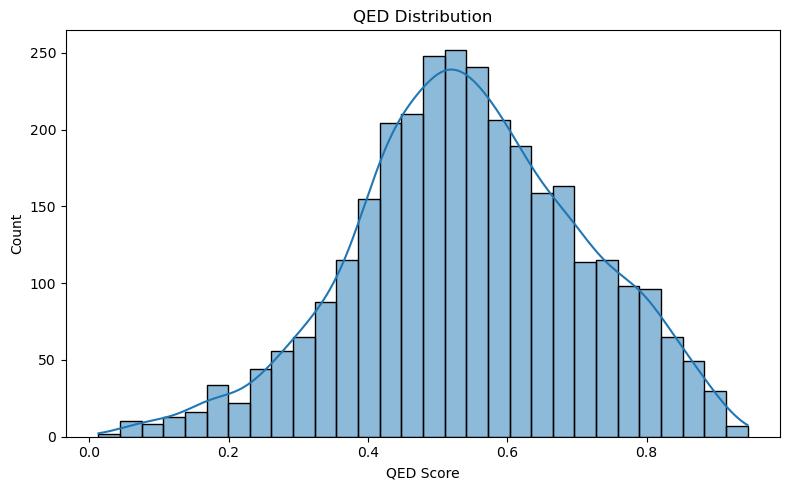

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(druglikeness_df["QED"], bins=30, kde=True)
plt.title("QED Distribution")
plt.xlabel("QED Score")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "druglikeness_summary.png")
plt.show()


In [6]:
feature_importance = pd.read_csv(METRICS_DIR / "feature_importances.csv")
feature_importance.head()


,assay,feature,importance
0,NR-AR,MaxAbsEStateIndex,0.013049
1,NR-AR,MaxEStateIndex,0.012821
2,NR-AR,MinAbsEStateIndex,0.008326
3,NR-AR,MinEStateIndex,0.008722
4,NR-AR,qed,0.017779


In [7]:
top_features = (
    feature_importance
    .groupby("feature")["importance"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

top_features


['BCUT2D_MWLOW',
 'VSA_EState4',
 'qed',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_MRHI',
 'MinPartialCharge',
 'FpDensityMorgan3',
 'PEOE_VSA7',
 'BCUT2D_MWHI']

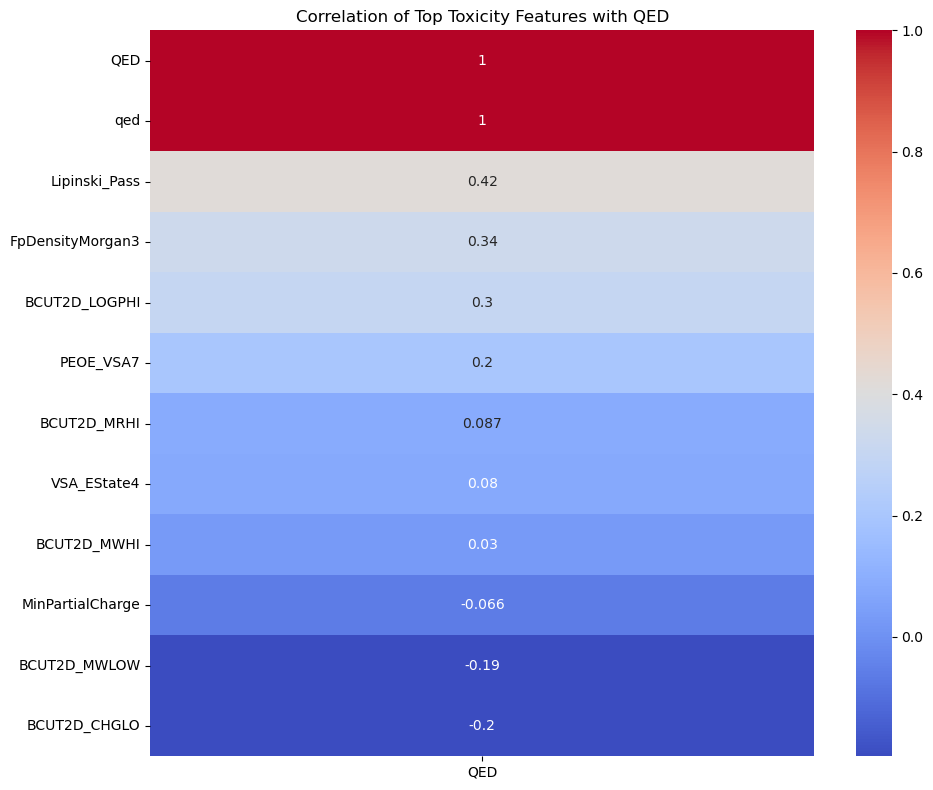

In [8]:
analysis_df = pd.concat(
    [druglikeness_df[["QED", "Lipinski_Pass"]], X_desc[top_features]],
    axis=1
)

corr = analysis_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr[["QED"]].sort_values("QED", ascending=False),
            annot=True, cmap="coolwarm")
plt.title("Correlation of Top Toxicity Features with QED")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "feature_vs_qed_correlation.png")
plt.show()



In [9]:
# Load toxicity labels
tox_labels = pd.read_csv(DATA_PROCESSED / "tox21_labels.csv")

# Mean toxicity score across all assays
toxicity_score = tox_labels.mean(axis=1)

# Create overlay dataframe
overlay_df = pd.DataFrame({
    "QED": druglikeness_df["QED"],
    "Toxicity_Score": toxicity_score
})


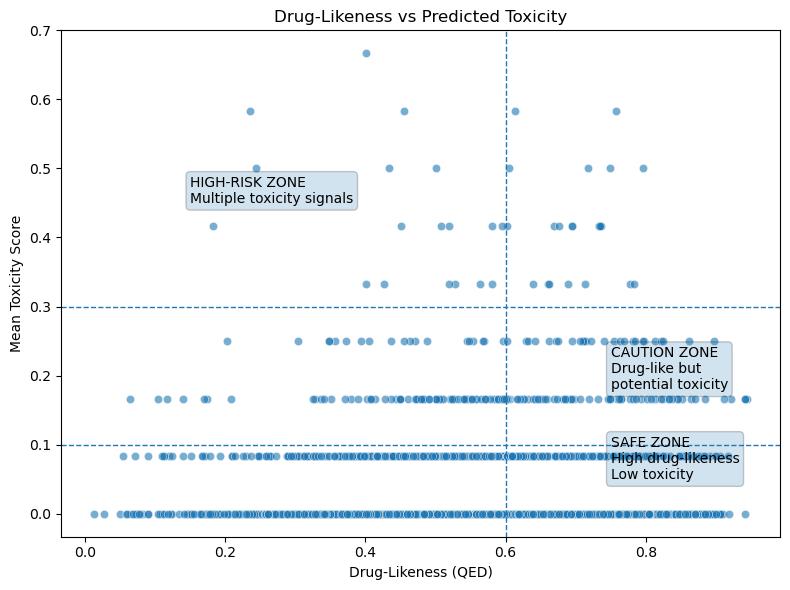

In [10]:
plt.figure(figsize=(8,6))

sns.scatterplot(
    data=overlay_df,
    x="QED",
    y="Toxicity_Score",
    alpha=0.6
)

# --- Zone boundaries ---
plt.axvline(0.6, linestyle="--", linewidth=1)
plt.axhline(0.1, linestyle="--", linewidth=1)
plt.axhline(0.3, linestyle="--", linewidth=1)

# --- Zone annotations ---
plt.text(
    0.75, 0.05,
    "SAFE ZONE\nHigh drug-likeness\nLow toxicity",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.2)
)

plt.text(
    0.75, 0.18,
    "CAUTION ZONE\nDrug-like but\npotential toxicity",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.2)
)

plt.text(
    0.15, 0.45,
    "HIGH-RISK ZONE\nMultiple toxicity signals",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.2)
)

plt.xlabel("Drug-Likeness (QED)")
plt.ylabel("Mean Toxicity Score")
plt.title("Drug-Likeness vs Predicted Toxicity")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "druglikeness_vs_toxicity_annotated.png")
plt.show()


In [11]:
final_druglikeness = pd.concat(
    [df[["smiles"]], druglikeness_df, overlay_df["Toxicity_Score"]],
    axis=1
)

final_druglikeness.to_csv(METRICS_DIR / "drug_likeness.csv", index=False)


In [12]:
# ===============================
# Ranking Top 50 Safest Drug-like Molecules
# ===============================

ranking_df = final_druglikeness.copy()

# Keep only drug-like molecules
ranking_df = ranking_df[ranking_df["Lipinski_Pass"] == True]

# Drop rows with missing values
ranking_df = ranking_df.dropna(subset=["QED", "Toxicity_Score"])

# Rank: lowest toxicity first, highest QED next
ranking_df = ranking_df.sort_values(
    by=["Toxicity_Score", "QED"],
    ascending=[True, False]
)

# Select top 50
top_50_safest = ranking_df.head(50)

top_50_safest.head()


,smiles,MolWt,LogP,HBD,HBA,QED,Lipinski_Pass,Toxicity_Score
1503,CC(C)C(O)(c1ccc(OC(F)(F)F)cc1)c1cncnc1,312.291,3.2671,1,4,0.941210,True,0.0
2482,COc1ccc(C2CNC(=O)C2)cc1OC1CCCC1,275.348,2.6201,1,3,0.918549,True,0.0
1289,CCn1cc(C(=O)O)c(=O)c2cnc(N3CCCC3)nc21,288.307,1.1098,1,6,0.909831,True,0.0
1911,CC(C)C1(C)N=C(c2nc3ccccc3cc2C(=O)O)NC1=O,311.341,2.2241,2,4,0.908900,True,0.0
1371,COc1cccc([C@@]2(O)CCCC[C@@H]2CN(C)C)c1,263.381,2.6346,1,3,0.906176,True,0.0


In [13]:
top_50_safest.to_csv(
    METRICS_DIR / "top_50_safest_druglike_molecules.csv",
    index=False
)


In [14]:
top_50_safest[["QED", "Toxicity_Score"]].describe() 


,QED,Toxicity_Score
count,50.000000,50.0
mean,0.883299,0.0
std,0.017737,0.0
min,0.858391,0.0
25%,0.870584,0.0
50%,0.881318,0.0
75%,0.895188,0.0
max,0.941210,0.0


## Key Insights & Final Takeaway

- Most compounds satisfy **Lipinski’s Rule of Five**, suggesting acceptable oral drug-like properties.
- **QED scores** display moderate variability, reflecting chemical diversity within the dataset.
- Several top toxicity-driving descriptors show a **negative correlation with QED**, indicating that:
  - Compounds with higher predicted toxicity often exhibit poorer drug-likeness.
- The drug-likeness vs toxicity overlay reveals a **desirable prioritization region**:
  - **High QED + Low predicted toxicity**, representing the safest drug-like candidates.
- Ranking the **top 50 safest drug-like molecules** demonstrates how toxicity predictions can be translated into actionable compound prioritization.

### Conclusion
This stage integrates **machine learning–based toxicity modeling** with **medicinal chemistry heuristics**, demonstrating a practical, decision-oriented approach to early-stage drug discovery and compound triage.
